<a href="https://colab.research.google.com/github/JdavidRamirez/End-to-end-dataProject/blob/main/EducationProgramInsight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
##Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

In [30]:
#Import CSV files from URLs into two separate DataFrames (bd1 and bd2).

bd1=pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vS9IwGj-SwAzPqx6_gNwxigmdziGS0Cgu7-UQqaRp5lyUOs41pkbirF8vIgQxlbsmFMr1nimwC_sHbQ/pub?gid=260434784&single=true&output=csv')
bd2=pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vSbbYrc301ntoQC-3hdbLjR9UtcBCVpm3fnJrCJSEtQw5-M6bevEnCiCK8L_iWpZLKfklnbHtrXFvR9/pub?gid=0&single=true&output=csv')

In [31]:
bd1.info() ,bd2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1668 entries, 0 to 1667
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Fecha evento                    1668 non-null   object
 1   Programa                        1668 non-null   object
 2   Sede que activa                 1668 non-null   object
 3   Tipo Doc                        1668 non-null   object
 4   N° de Documento                 1668 non-null   object
 5   Nombres y Apellidos Estudiante  1668 non-null   object
 6   Genero                          1668 non-null   object
 7   Fecha de Nacimiento             1668 non-null   object
 8   Municipio IE                    1668 non-null   object
 9   Estado Civil                    1668 non-null   object
 10  Institucion Educativa           1668 non-null   object
 11  Codigo DANE                     1668 non-null   int64 
 12  Grado                           1668 non-null   

(None, None)

In [32]:
#Keep only the necessary columns related to event dates, student information, and attendance.
bd1=bd1[['Fecha evento','N° de Documento','Genero','Fecha de Nacimiento','Grado','Asistencia']].copy()
bd2=bd2[['Fecha evento','N° de Documento','Genero','Fecha de Nacimiento','Grado','Asistencia']].copy()



In [33]:
bd1.info() ,bd2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1668 entries, 0 to 1667
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Fecha evento         1668 non-null   object
 1   N° de Documento      1668 non-null   object
 2   Genero               1668 non-null   object
 3   Fecha de Nacimiento  1668 non-null   object
 4   Grado                1668 non-null   object
 5   Asistencia           1668 non-null   object
dtypes: object(6)
memory usage: 78.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1220 entries, 0 to 1219
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Fecha evento         1220 non-null   object
 1   N° de Documento      1220 non-null   int64 
 2   Genero               1220 non-null   object
 3   Fecha de Nacimiento  1220 non-null   object
 4   Grado                1220 non-null   object
 5   Asisten

(None, None)

In [34]:
#Merge the two DataFrames into one (df) for further analysis.
df=pd.concat([bd1,bd2], ignore_index=True)


In [35]:
#Convert string-based date columns into datetime objects for easier manipulation.
df['Fecha evento']=pd.to_datetime(df['Fecha evento'])
df['Fecha de Nacimiento']=pd.to_datetime(df['Fecha de Nacimiento'],format="mixed")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2888 entries, 0 to 2887
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Fecha evento         2888 non-null   datetime64[ns]
 1   N° de Documento      2888 non-null   object        
 2   Genero               2888 non-null   object        
 3   Fecha de Nacimiento  2888 non-null   datetime64[ns]
 4   Grado                2888 non-null   object        
 5   Asistencia           2888 non-null   object        
dtypes: datetime64[ns](2), object(4)
memory usage: 135.5+ KB


<ipython-input-35-41c4c1db9391>:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Fecha evento']=pd.to_datetime(df['Fecha evento'])


In [36]:
#Calculate students' ages in years and months as of the current date and store the results in a new column, Edad.
from datetime import datetime

# Function to calculate the age in years and months
def calculate_age(birthdate):
    today = datetime.today()
    years = today.year - birthdate.year
    months = today.month - birthdate.month

    # Adjust if the birthdate's month hasn't occurred yet this year
    if months < 0:
        years -= 1
        months += 12

    # Calculate age in years and months as a decimal (e.g., 15.6)
    return years + months / 12

# Apply the function to the 'birth_date' column
df['Edad'] = df['Fecha de Nacimiento'].apply(calculate_age)

# Display the DataFrame
df.head()

,Fecha evento,N° de Documento,Genero,Fecha de Nacimiento,Grado,Asistencia,Edad
0,2022-04-25,1034920269,M,2008-04-02,7-2,NO,16.666667
1,2022-04-25,1011396343,M,2007-05-09,7-2,NO,17.583333
2,2022-04-25,1032018095,F,2009-07-07,7-2,SI,15.416667
3,2022-04-25,1020225405,F,2009-08-07,7-2,SI,15.333333
4,2022-04-25,1032014849,F,2008-10-22,7-2,SI,16.166667


In [37]:
#Convert categorical data (Asistencia and Genero) into numerical formats for analysis.
# Map 'Yes' to 1 and 'No' to 0
df['Asistencia'] = df['Asistencia'].map({'SI': 1, 'NO': 0})
df['Genero']= df['Genero'].map({'M':1,'F':0})
df.head()

,Fecha evento,N° de Documento,Genero,Fecha de Nacimiento,Grado,Asistencia,Edad
0,2022-04-25,1034920269,1,2008-04-02,7-2,0,16.666667
1,2022-04-25,1011396343,1,2007-05-09,7-2,0,17.583333
2,2022-04-25,1032018095,0,2009-07-07,7-2,1,15.416667
3,2022-04-25,1020225405,0,2009-08-07,7-2,1,15.333333
4,2022-04-25,1032014849,0,2008-10-22,7-2,1,16.166667


In [38]:
#Create  an Events column to track the number of workshops attended by each student.
df["Events"] = df.groupby('N° de Documento').cumcount() + 1
df

,Fecha evento,N° de Documento,Genero,Fecha de Nacimiento,Grado,Asistencia,Edad,Events
0,2022-04-25,1034920269,1,2008-04-02,7-2,0,16.666667,1
1,2022-04-25,1011396343,1,2007-05-09,7-2,0,17.583333,1
2,2022-04-25,1032018095,0,2009-07-07,7-2,1,15.416667,1
3,2022-04-25,1020225405,0,2009-08-07,7-2,1,15.333333,1
4,2022-04-25,1032014849,0,2008-10-22,7-2,1,16.166667,1
...,...,...,...,...,...,...,...,...
2883,2023-06-08,1011393218,0,2005-08-19,11-6,1,19.333333,4
2884,2023-06-08,1033489919,0,2007-04-30,11-6,1,17.666667,4
2885,2023-06-08,1025886522,0,2005-12-15,11-6,1,19.000000,4
2886,2023-06-08,1018236349,1,2007-02-27,11-6,1,17.833333,4


In [39]:
#Remove rows with invalid event counts (Events > 4) or grades with insufficient representation.
df=df[df['Events']<=4]
df['Events'].value_counts()

df=df[df['Grado']!='8']
df=df[df['Grado']!='9']
df=df[df['Grado']!='8-2']



In [40]:
#Renaming all columns
new_column_names = ['Fecha_evento', 'N_documento','Genero','Fecha_nacimiento','Grado','Asistencia','Edad','Eventos']
df.columns = new_column_names

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2820 entries, 0 to 2887
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Fecha_evento      2820 non-null   datetime64[ns]
 1   N_documento       2820 non-null   object        
 2   Genero            2820 non-null   int64         
 3   Fecha_nacimiento  2820 non-null   datetime64[ns]
 4   Grado             2820 non-null   object        
 5   Asistencia        2820 non-null   int64         
 6   Edad              2820 non-null   float64       
 7   Eventos           2820 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(3), object(2)
memory usage: 198.3+ KB


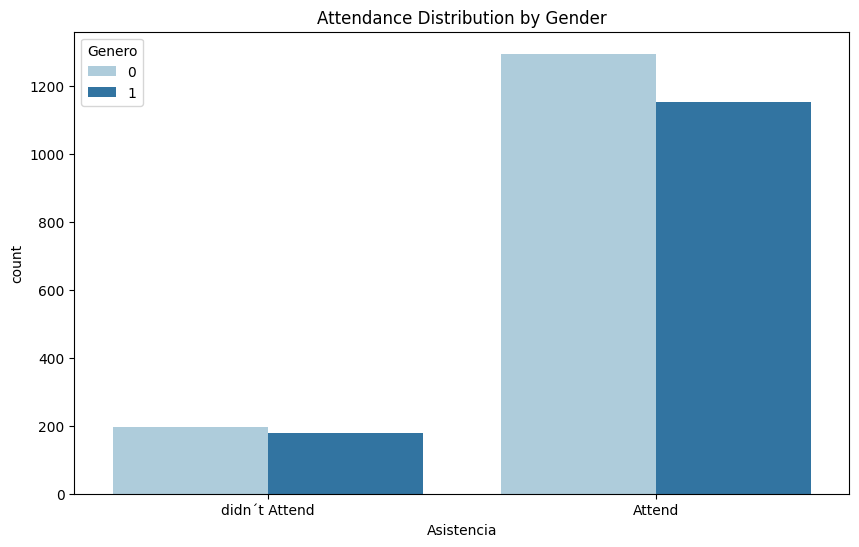

In [42]:
#Attendance Distribution by Gender
import seaborn as sns
import math
plt.figure(figsize=(10,6));
plot=sns.countplot(data = df, x = "Asistencia", hue = "Genero", palette='Paired');
plt.title('Attendance Distribution by Gender')
plt.xticks(range(2),['didn´t Attend','Attend'])
plt.show()

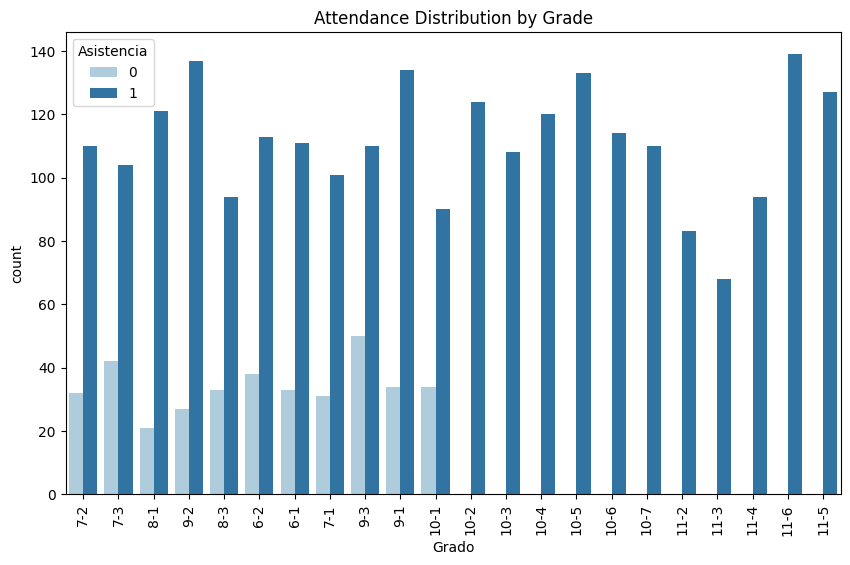

In [43]:
#Attendance Distribution by grade
import seaborn as sns
import math
plt.figure(figsize=(10,6));
plot=sns.countplot(data = df, x = "Grado", hue = "Asistencia", palette='Paired');
plt.title('Attendance Distribution by Grade')
plt.xticks(rotation=90)
#plt.xticks(range(2),['No asistio','Asistio'])
plt.show()

In [44]:
 #tabla de contingencia en porcentajes relativos total
pd.crosstab(index=df['Asistencia'], columns=df['Genero'],
margins=True).apply(lambda r: r/len(df) *100,
axis=1)

Genero,0,1,All
Asistencia,,,
0,6.985816,6.312057,13.297872
1,45.886525,40.815603,86.702128
All,52.872340,47.127660,100.000000


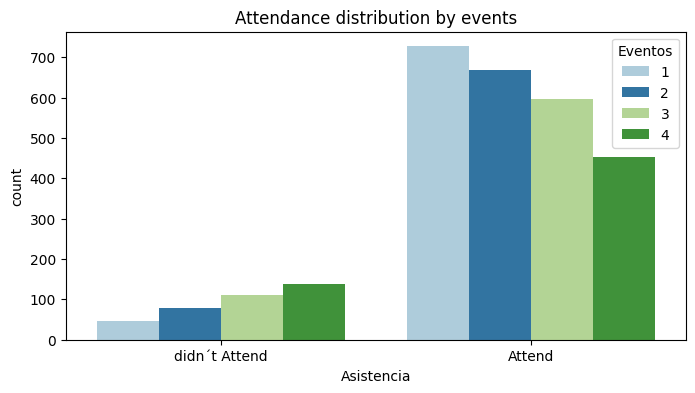

In [47]:
#Display attendance distribution across events
plt.figure(figsize=(8,4));
sns.countplot(data = df, x = "Asistencia", hue = "Eventos",palette='Paired');
plt.title('Attendance distribution by events')
plt.xticks(range(2),['didn´t Attend','Attend'])
plt.show()

In [48]:
#Create an Events column to track the number of workshops attended by each student.
pd.crosstab(index=df['Grado'], columns=df['Eventos'])

Eventos,1,2,3,4
Grado,,,,
10-1,31,31,31,31
10-2,33,32,32,27
10-3,36,31,28,13
10-4,36,34,30,20
10-5,37,36,34,26
10-6,34,33,28,19
10-7,34,29,27,20
11-2,22,22,22,17
11-3,25,23,15,5


#Connect data frame to SQLite

In [49]:
import sqlite3

# Create or connect to SQLite database
conn = sqlite3.connect("Workshop.db")  # this create a file named Workshop.db



In [50]:
# Create a cursor to execute SQL commands
cursor = conn.cursor()

# SQL command to create a table
cursor.execute("""
CREATE TABLE IF NOT EXISTS WorkshopAttendance (
    Fecha_evento TEXT,
    N_documento INTEGER,
    Genero TEXT,
    Fecha_nacimiento TEXT,
    Grado TEXT,
    Asistencia TEXT,
    Edad REAL,
    Eventos INTEGER
)
""")

# Commit the changes
conn.commit()


In [51]:
# Insert the DataFrame into the SQLite table
df.to_sql(
    name='WorkshopAttendance',   # Table name
    con=conn,                    # SQLite connection
    if_exists='append',          # Append to the table if it exists
    index=False                  # Do not write DataFrame index as a column
)


2820

In [54]:
# Query data from the SQLite table
result_df = pd.read_sql("SELECT * FROM WorkshopAttendance", conn)
result_df

,Fecha_evento,N_documento,Genero,Fecha_nacimiento,Grado,Asistencia,Edad,Eventos
0,2022-04-25 00:00:00,1034920269,1,2008-04-02 00:00:00,7-2,0,16.666667,1
1,2022-04-25 00:00:00,1011396343,1,2007-05-09 00:00:00,7-2,0,17.583333,1
2,2022-04-25 00:00:00,1032018095,0,2009-07-07 00:00:00,7-2,1,15.416667,1
3,2022-04-25 00:00:00,1020225405,0,2009-08-07 00:00:00,7-2,1,15.333333,1
4,2022-04-25 00:00:00,1032014849,0,2008-10-22 00:00:00,7-2,1,16.166667,1
...,...,...,...,...,...,...,...,...
2815,2023-06-08 00:00:00,1011393218,0,2005-08-19 00:00:00,11-6,1,19.333333,4
2816,2023-06-08 00:00:00,1033489919,0,2007-04-30 00:00:00,11-6,1,17.666667,4
2817,2023-06-08 00:00:00,1025886522,0,2005-12-15 00:00:00,11-6,1,19.000000,4
2818,2023-06-08 00:00:00,1018236349,1,2007-02-27 00:00:00,11-6,1,17.833333,4


In [55]:
conn.close()